In [1]:
from posteriordb import PosteriorDatabase
import os
import json
import bridgestan as bs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stein_thinning.stein import ksd
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_centkgm

from stein_pi_thinning.target import PiTargetCentKGM
from stein_pi_thinning.mcmc import mala_adapt
from stein_pi_thinning.util import flat, nearestPD
from stein_pi_thinning.progress_bar import disable_progress_bar

import wasserstein


np.random.seed(1234)
disable_progress_bar()

### Model Preparation

In [2]:
# Load DataBase Locally
pdb_path = os.path.join("../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("gp_pois_regr-gp_pois_regr")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

In [3]:
# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s

gs_matrix = np.array([df.values[0,i] for i in range(df.shape[1])]).T

### P Target and Q Target

In [4]:
# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [5]:
# Construct log-Pi-pdf and its gradient
# Using Centralised KGM kernel
# linv is -Hessian Matrix at P mode

# Stein Centralised KGM kernel
dim = model.param_num()
x_unconstrain_map = model.param_unconstrain(np.mean(gs_chains, axis=1))
linv = -hess_log_p(x_unconstrain_map)
s = 3.0

stein_q_kgm = PiTargetCentKGM(log_p, grad_log_p, hess_log_p, linv, s, x_unconstrain_map)
log_q = stein_q_kgm.log_q
grad_log_q = stein_q_kgm.grad_log_q

In [6]:
# MALA With pre-conditioning
# Parameters
nits = 100_000 # the number of iterations

alpha = 10 * [1]
epoch = 9 * [1_000] + [nits]

_, _, x_p_epoch, _, _, nacc_p = mala_adapt(log_p, grad_log_p, np.zeros_like(x_unconstrain_map), 0.1, np.eye(dim), alpha, epoch)
print('acc_p =', np.mean(nacc_p[-1]))

acc_p = 0.51987


In [7]:
_, _, x_q_epoch, _, _, nacc_q = mala_adapt(log_q, grad_log_q, np.zeros_like(x_unconstrain_map), 0.1, np.eye(dim), alpha, epoch)
print('acc_q =', np.mean(nacc_q[-1]))

acc_q = 0.60379


In [8]:
x_p_unconstrain = np.array(x_p_epoch[-1], dtype=np.float64)
grad_x_p_unconstrain = np.array([grad_log_p(i) for i in x_p_unconstrain])

x_q_unconstrain = np.array(x_q_epoch[-1], dtype=np.float64)
grad_x_q_unconstrain = np.array([grad_log_p(i) for i in x_q_unconstrain])

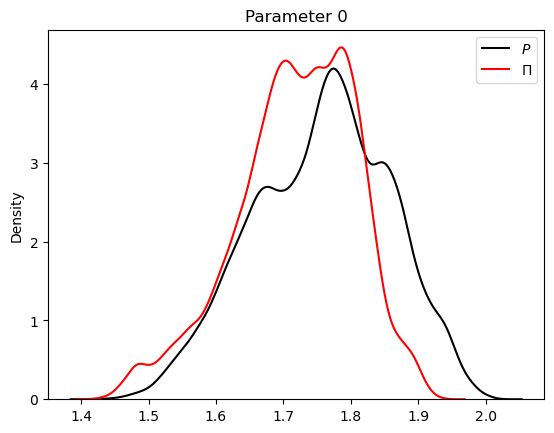

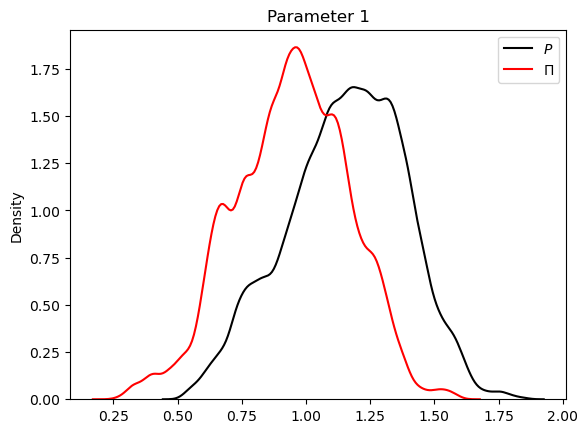

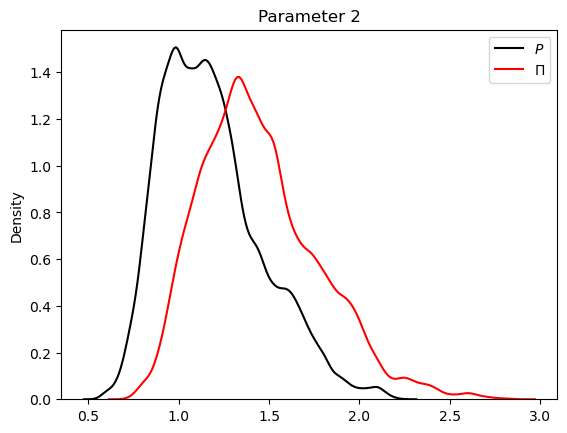

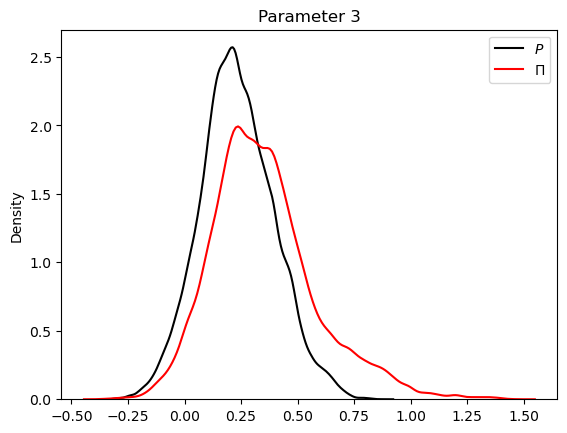

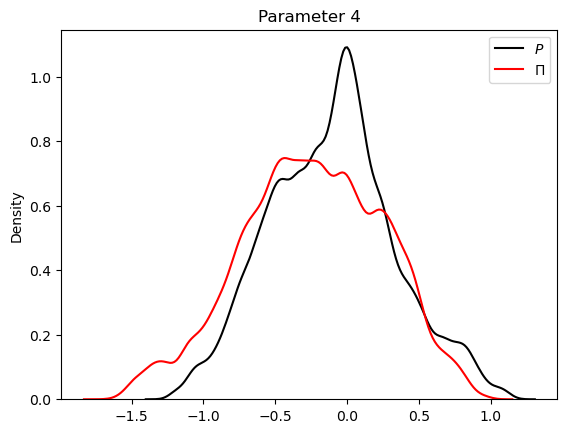

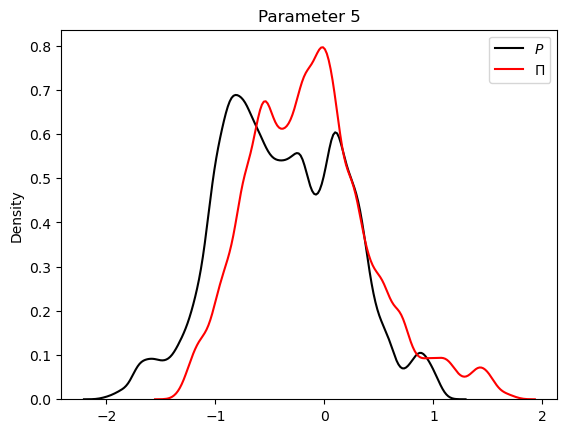

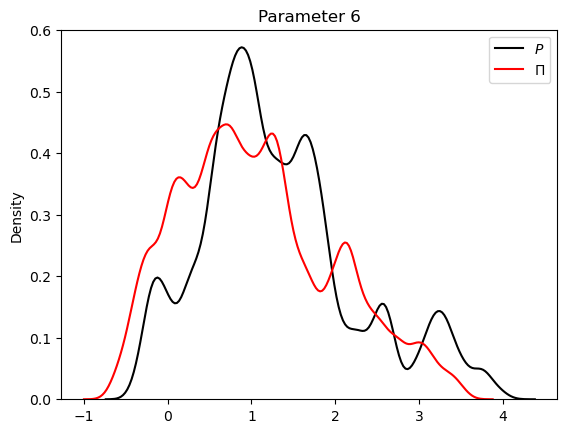

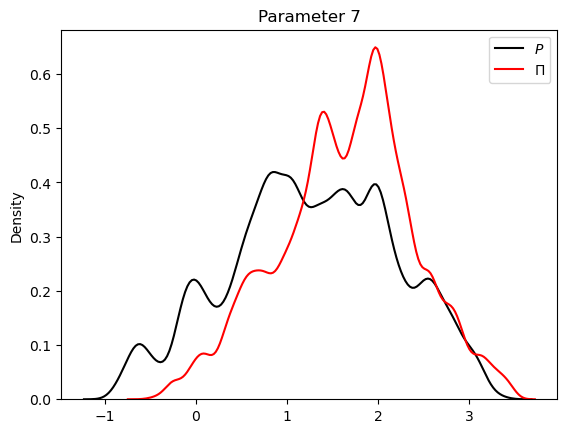

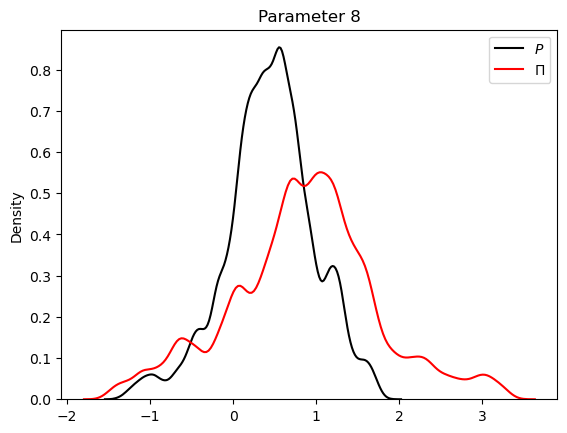

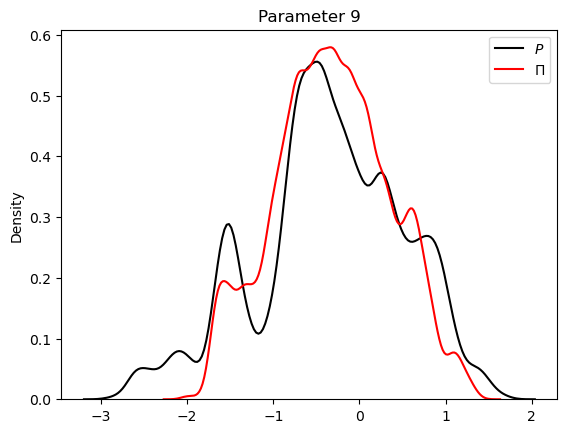

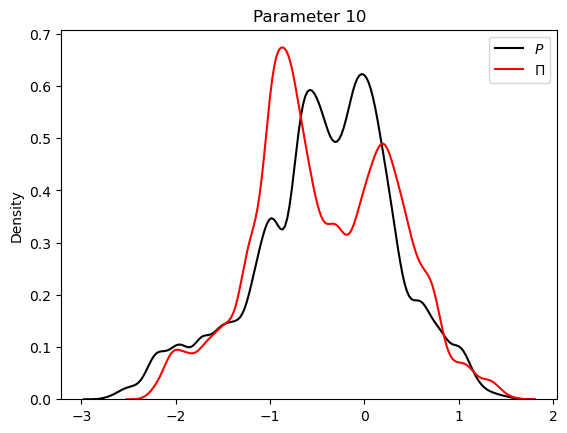

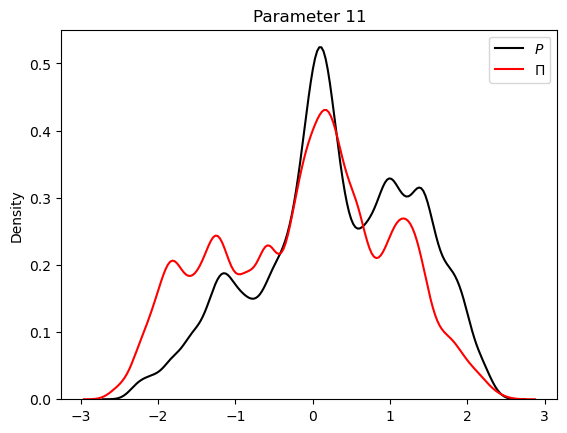

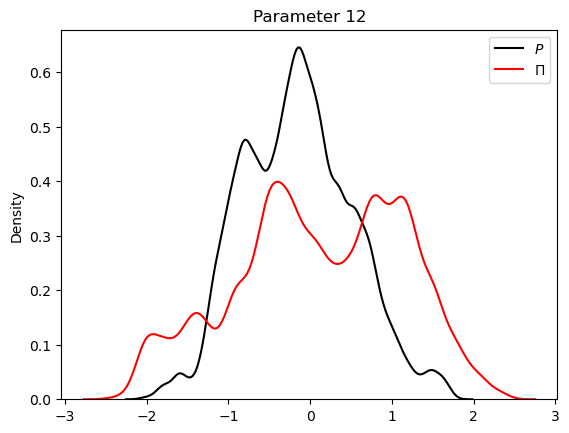

In [9]:
for i in range(dim):
    # plt.hist(x_p_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='p')
    # plt.hist(x_q_unconstrain[:,i].flatten(), bins=100, density=True, alpha=0.5, label='q')
    sns.kdeplot(x_p_unconstrain[:,i].flatten(), label='$P$', color="black")
    sns.kdeplot(x_q_unconstrain[:,i].flatten(), label='$\Pi$', color="red")

    plt.title(f"Parameter {i}")
    plt.legend()
    plt.show()

### Thinning

In [10]:
fixed_ratio = 0.1
iteration_list = [10, 20, 50, 100, 200, 500, 1000, 2000]

#IMQ
vfk0_imq = make_imq(x_p_unconstrain, grad_x_p_unconstrain, pre=nearestPD(linv))

res_ksd_p_imq = []
res_ksd_q_imq = []
res_ksd_p_thinning_imq = []
res_ksd_q_thinning_imq = []

In [11]:
# IMQ Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_imq)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_imq)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_imq)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_imq)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_imq.append(ks_p[-1])
    res_ksd_q_imq.append(ks_q[-1])

    res_ksd_p_thinning_imq.append(ks_p_thinning[-1])
    res_ksd_q_thinning_imq.append(ks_q_thinning[-1])

10 380955.39670177206
10 380955.4035079111
20 269376.1441869539
20 269376.14742759906
50 170368.4326699509
50 170368.43457700923
100 120468.67422738364
100 120468.6776690442
200 85184.21661802146
200 85184.21944640715
500 53875.22911622456
500 59017.35805334281
1000 38095.53992087168
1000 41731.57433840128
2000 26937.614639144223
2000 28887.374300204552


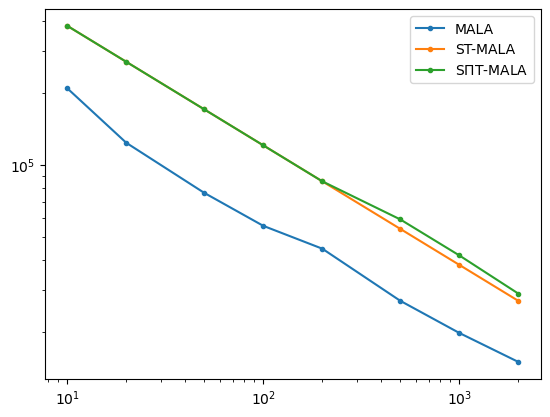

In [12]:
plt.loglog(iteration_list, res_ksd_p_imq, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_imq, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [13]:
#KGM
vfk0_centkgm = make_centkgm(x_p_unconstrain, grad_x_p_unconstrain, x_map=x_unconstrain_map, pre=nearestPD(linv), s=s)

res_ksd_p_centkgm = []
res_ksd_q_centkgm = []
res_ksd_p_thinning_centkgm = []
res_ksd_q_thinning_centkgm = []

In [14]:
# KGM Thinning
# Compute KSD
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    # print(f"No.{i} Index Calculation Begin")

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    ks_p = ksd(x_p_unconstrain_cutting, grad_x_p_unconstrain_cutting, vfk0_centkgm)
    ks_p_thinning = ksd(x_p_thinning_unconstrain_cutting, grad_x_p_thinning_unconstrain_cutting, vfk0_centkgm)

    ks_q = ksd(x_q_unconstrain_cutting, grad_x_q_unconstrain_cutting, vfk0_centkgm)
    ks_q_thinning = ksd(x_q_thinning_unconstrain_cutting, grad_x_q_thinning_unconstrain_cutting, vfk0_centkgm)

    print(i, ks_p_thinning[-1])
    print(i, ks_q_thinning[-1])

    res_ksd_p_centkgm.append(ks_p[-1])
    res_ksd_q_centkgm.append(ks_q[-1])

    res_ksd_p_thinning_centkgm.append(ks_p_thinning[-1])
    res_ksd_q_thinning_centkgm.append(ks_q_thinning[-1])

10 3.721138777293059e+16
10 3.062331446487681e+16
20 2.5428223888084324e+16
20 2.950700343097518e+16
50 1.6429629656721028e+16
50 1.9629178826318156e+16
100 1.1577230617000264e+16
100 1.2729135554888948e+16
200 8308454186027835.0
200 8319410219722664.0
500 3508757048713872.5
500 8027789580064699.0
1000 1731143013654734.5
1000 3698197081947470.0
2000 996219911372245.2
2000 2269503728123613.0


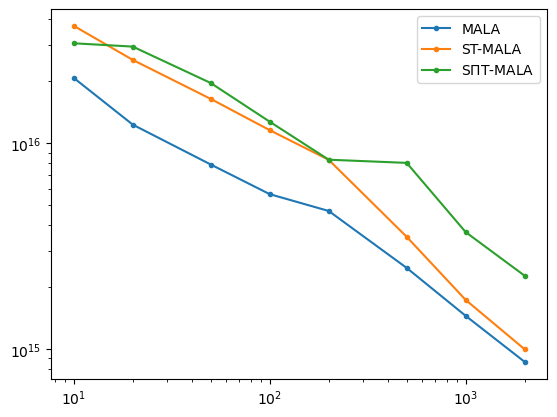

In [15]:
plt.loglog(iteration_list, res_ksd_p_centkgm, label="MALA", marker=".")
# plt.loglog(iteration_list, res_ksd_q_centkgm, label="$Pi$", marker=".")
plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

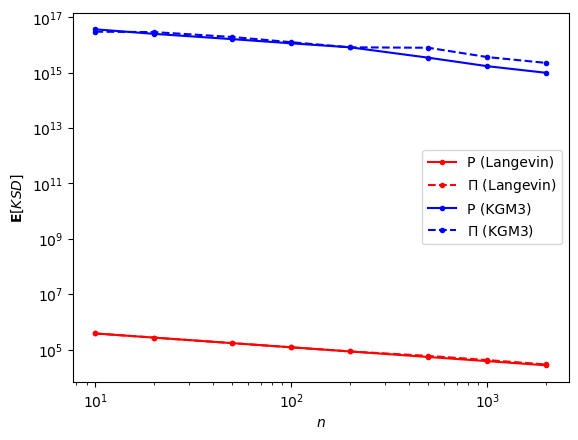

In [20]:
plt.loglog(iteration_list, res_ksd_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_ksd_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_ksd_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_ksd_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$KSD$]')
plt.legend()

### WasserStein

In [21]:
gs = np.zeros_like(gs_chains.T)
# gs = np.zeros_like(gs_matrix)

for i in range(gs_chains.T.shape[0]):
    gs[i] = model.param_unconstrain(gs_chains.T[i].astype(np.float64))
# for i in range(gs_matrix.shape[0]):
#     gs[i] = model.param_unconstrain(gs_matrix[i].astype(np.float64))
emd = wasserstein.EMD(n_iter_max=1_000_000)
gs_weights = np.repeat(1/gs.shape[0], gs.shape[0])

In [22]:
#IMQ
res_wass_p_imq = []
res_wass_q_imq = []
res_wass_p_thinning_imq = []
res_wass_q_thinning_imq = []

In [23]:
# IMQ Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_imq.append(wass_p)
    res_wass_q_imq.append(wass_q)

    res_wass_p_thinning_imq.append(wass_p_thinning)
    res_wass_q_thinning_imq.append(wass_q_thinning)

10 9.52195422588689
10 10.722493147930262
20 9.51845803436092
20 10.706177382295886
50 9.580958808136804
50 10.700221687543621
100 9.555092916205775
100 10.692291245599325
200 9.584894369582026
200 10.678681071353513
500 9.655922993016484
500 10.521288046217007
1000 9.760082360350307
1000 10.488570819218571
2000 9.980937674632944
2000 10.508730988999302


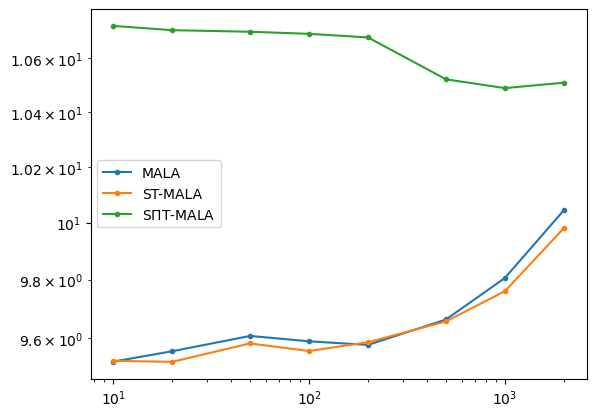

In [24]:
plt.loglog(iteration_list, res_wass_p_imq, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_imq, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_imq, label="S$\Pi$T-MALA", marker=".")
plt.legend()

In [25]:
#KGM
res_wass_p_centkgm = []
res_wass_q_centkgm = []
res_wass_p_thinning_centkgm = []
res_wass_q_thinning_centkgm = []

In [26]:
# KGM Thinning
# Compute WasserStein
for i in iteration_list:
    thinning_number = int(fixed_ratio * i)

    x_p_unconstrain_cutting = x_p_unconstrain[0:i,:]
    x_q_unconstrain_cutting = x_q_unconstrain[0:i,:]
    grad_x_p_unconstrain_cutting = grad_x_p_unconstrain[0:i,:]
    grad_x_q_unconstrain_cutting = grad_x_q_unconstrain[0:i,:]

    idx_p = thin(x_p_unconstrain_cutting,\
                    grad_x_p_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map
                    )
    idx_q = thin(x_q_unconstrain_cutting,\
                    grad_x_q_unconstrain_cutting,\
                    thinning_number,\
                    pre=nearestPD(linv),\
                    stnd=False,
                    kern='centkgm',
                    xmp=x_unconstrain_map)

    x_p_thinning_unconstrain_cutting = x_p_unconstrain_cutting[idx_p]
    # grad_x_p_thinning_unconstrain_cutting = grad_x_p_unconstrain_cutting[idx_p]

    x_q_thinning_unconstrain_cutting = x_q_unconstrain_cutting[idx_p]
    # grad_x_q_thinning_unconstrain_cutting = grad_x_q_unconstrain_cutting[idx_p]

    original_weights = np.repeat(1/i, i)
    thinning_weights = np.repeat(1/thinning_number, thinning_number)

    wass_p = emd(original_weights, x_p_unconstrain_cutting, gs_weights, gs)
    wass_p_thinning = emd(thinning_weights, x_p_thinning_unconstrain_cutting, gs_weights, gs)

    wass_q = emd(original_weights, x_q_unconstrain_cutting, gs_weights, gs)
    wass_q_thinning = emd(thinning_weights, x_q_thinning_unconstrain_cutting, gs_weights, gs)

    print(i, wass_p_thinning)
    print(i, wass_q_thinning)

    res_wass_p_centkgm.append(wass_p)
    res_wass_q_centkgm.append(wass_q)

    res_wass_p_thinning_centkgm.append(wass_p_thinning)
    res_wass_q_thinning_centkgm.append(wass_q_thinning)

10 9.521220495863517
10 10.702665712759897
20 9.592657121248704
20 10.668793393477465
50 9.596899375513411
50 10.680610188042492
100 9.594928295312416
100 10.674152393648955
200 9.615227667607913
200 10.657886812065735
500 9.74420845384673
500 10.174712974578512
1000 10.046736069776111
1000 10.559468653330235
2000 10.274992391236466
2000 10.642071177550426


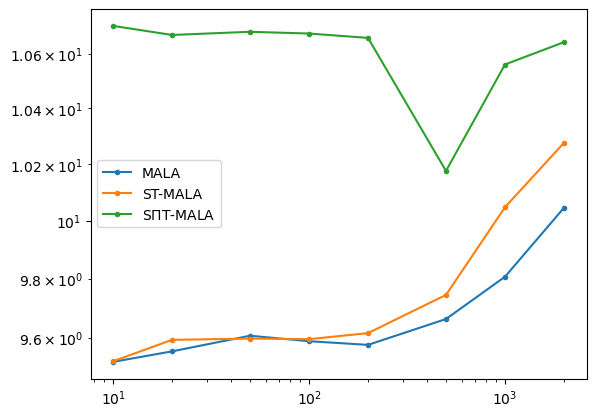

In [27]:
plt.loglog(iteration_list, res_wass_p_centkgm, label="MALA", marker=".")
plt.loglog(iteration_list, res_wass_p_thinning_centkgm, label="ST-MALA", marker=".")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, label="S$\Pi$T-MALA", marker=".")
plt.legend()

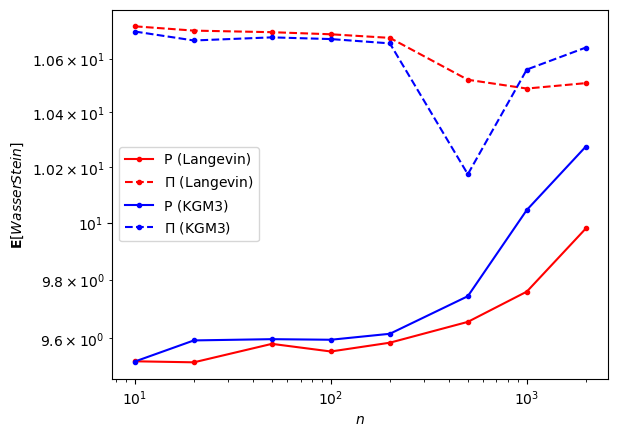

In [28]:
plt.loglog(iteration_list, res_wass_p_thinning_imq, marker=".", color="red", linestyle="-", label="P (Langevin)")
plt.loglog(iteration_list, res_wass_q_thinning_imq, marker=".", color="red", linestyle="--", label="$\Pi$ (Langevin)")

plt.loglog(iteration_list, res_wass_p_thinning_centkgm, marker=".", color="blue", linestyle="-", label="P (KGM3)")
plt.loglog(iteration_list, res_wass_q_thinning_centkgm, marker=".", color="blue", linestyle="--", label="$\Pi$ (KGM3)")

plt.xlabel('$n$')
plt.ylabel(r'$\bf{E}$[$WasserStein$]')
plt.legend()